In [ ]:
#!pip install statsmodels

## Import Libraries

In [1]:
# import library
import pandas as pd
from datetime import datetime
import geopandas as gpd
from geopandas import sjoin
from geodatasets import get_path
import matplotlib.pyplot as plt
import nest_asyncio
import numpy as np
from PIL import Image as im
#from streetlevel import streetview
import time
from multiprocessing.pool import ThreadPool
from tqdm import tqdm
import multiprocessing
import glob
import cv2
from collections import Counter
import seaborn as sns

C:\Users\Fan_Z\anaconda3\envs\tf-gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Fan_Z\anaconda3\envs\tf-gpu\lib\site-packages\numpy\.libs\libopenblas.noijjg62emaszi6nyurl6jbkm4evbgm7.gfortran-win_amd64.dll
C:\Users\Fan_Z\anaconda3\envs\tf-gpu\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


## Investigate the svi and road class information related to the cluster

In [5]:
points_with_nearest_road_info_with_svi_semantic = pd.read_csv('data/1216_kmeans/1216_clustering_result_k_7_with_location_with_road_with_svi.csv')

In [6]:
 points_with_nearest_road_info_with_svi_semantic.columns

Index(['Unnamed: 0.2', 'Unnamed: 0', 'day_svi_id', 'Unnamed: 0.1',
       'Unnamed: 0.1.1', 'svi_name', 'year', 'month', 'day_svi_lat',
       'day_svi_lon', 'day_svi_heading', 'GPS (Lat.) [deg]',
       'GPS (Long.) [deg]', 'lux', 'distance_err', 'selected', 'version',
       'total_area', 'total_luminosity', 'avg_luminosity', 'avg_distance',
       'mid_distance', 'weighted_lum_std', 'weighted_dist_std',
       'max_contour_size', 'cluster_label', 'geometry', 'index_right',
       'fclass', 'svi_construction', 'svi_flat', 'svi_human', 'svi_nature',
       'svi_object', 'svi_sky', 'svi_vehicle', 'svi_id'],
      dtype='object')

In [7]:
points_with_nearest_road_info_with_svi_semantic = points_with_nearest_road_info_with_svi_semantic.rename(columns={'cluster_label': 'cluster_id'})

In [20]:
points_with_nearest_road_info_summary = points_with_nearest_road_info_with_svi_semantic.groupby(['cluster_id','fclass']).count()[['Unnamed: 0']].reset_index()
points_with_nearest_road_info_summary.columns =['cluster_id','fclass','count']
points_with_nearest_road_info_summary.sort_values(by = ['cluster_id','fclass','count'])

# Pivoting the DataFrame to wide format
points_with_nearest_road_info_summary_wide = points_with_nearest_road_info_summary.pivot(index='cluster_id', columns='fclass', values='count').reset_index()

points_with_nearest_road_info_summary_wide.fillna(0, inplace=True)
# Merging "primary" and "primary_link" columns
points_with_nearest_road_info_summary_wide['primary'] = points_with_nearest_road_info_summary_wide['primary'] + points_with_nearest_road_info_summary_wide['primary_link']
points_with_nearest_road_info_summary_wide['motorway'] = points_with_nearest_road_info_summary_wide['motorway'] + points_with_nearest_road_info_summary_wide['motorway_link']
points_with_nearest_road_info_summary_wide['secondary'] = points_with_nearest_road_info_summary_wide['secondary'] + points_with_nearest_road_info_summary_wide['secondary_link']

# Dropping the "primary_link" column
points_with_nearest_road_info_summary_wide.drop(['primary_link','motorway_link','secondary_link'], axis=1, inplace=True)
road_columns = points_with_nearest_road_info_summary_wide.columns.drop('cluster_id')
points_with_nearest_road_info_summary_wide[road_columns] = points_with_nearest_road_info_summary_wide[road_columns].div(points_with_nearest_road_info_summary_wide[road_columns].sum(axis=1), axis=0)
points_with_nearest_road_info_summary_wide

fclass,cluster_id,living_street,motorway,primary,residential,secondary,service,tertiary,tertiary_link,trunk
0,-1,0.000000,0.000000,0.086420,0.388889,0.191358,0.117284,0.216049,0.000000,0.000000
1,0,0.000000,0.008571,0.037143,0.597143,0.082857,0.105714,0.168571,0.000000,0.000000
2,1,0.000000,0.013699,0.075965,0.473225,0.202989,0.084682,0.149440,0.000000,0.000000
3,2,0.000000,0.000000,0.075000,0.304167,0.383333,0.037500,0.187500,0.000000,0.012500
4,3,0.000000,0.007712,0.069409,0.372751,0.316195,0.051414,0.174807,0.005141,0.002571
5,4,0.002525,0.000000,0.063131,0.353535,0.328283,0.085859,0.161616,0.002525,0.002525
6,5,0.000000,0.000000,0.057851,0.376033,0.433884,0.037190,0.090909,0.000000,0.004132
7,6,0.000000,0.031128,0.101167,0.416342,0.249027,0.019455,0.182879,0.000000,0.000000


In [21]:
points_with_svi_summary = points_with_nearest_road_info_with_svi_semantic.groupby(['cluster_id']).mean().reset_index()[['cluster_id','svi_construction','svi_flat','svi_human','svi_nature','svi_object','svi_sky','svi_vehicle']]
svi_columns = points_with_svi_summary.columns.drop('cluster_id')
points_with_svi_summary [svi_columns ] = points_with_svi_summary [svi_columns ].div(points_with_svi_summary [svi_columns ].sum(axis=1), axis=0)
points_with_svi_summary #proportional_data = data.div(data.sum(axis=1), axis=0)
#points_with_svi_summary.columns =['cluster_id','svi_construction','mean']
#points_with_svi_summary.sort_values(by = ['cluster_id','svi_construction','mean'])

,cluster_id,svi_construction,svi_flat,svi_human,svi_nature,svi_object,svi_sky,svi_vehicle
0,-1,0.166444,0.354653,0.015926,0.178617,0.011786,0.230466,0.042109
1,0,0.070378,0.373299,0.009070,0.276707,0.010025,0.244526,0.015995
2,1,0.061089,0.374481,0.011124,0.269286,0.008611,0.255025,0.020384
3,2,0.140353,0.388506,0.014384,0.150252,0.012204,0.260314,0.033987
4,3,0.066488,0.380568,0.011294,0.244866,0.009855,0.266733,0.020195
5,4,0.140405,0.382972,0.016415,0.170120,0.010590,0.239804,0.039694
6,5,0.184094,0.386660,0.015122,0.106536,0.010553,0.250620,0.046415
7,6,0.055332,0.371350,0.010111,0.297646,0.009974,0.233942,0.021646


In [22]:
points_with_svi_road_summary = points_with_svi_summary.merge(points_with_nearest_road_info_summary_wide)
points_with_svi_road_summary 

,cluster_id,svi_construction,svi_flat,svi_human,svi_nature,svi_object,svi_sky,svi_vehicle,living_street,motorway,primary,residential,secondary,service,tertiary,tertiary_link,trunk
0,-1,0.166444,0.354653,0.015926,0.178617,0.011786,0.230466,0.042109,0.000000,0.000000,0.086420,0.388889,0.191358,0.117284,0.216049,0.000000,0.000000
1,0,0.070378,0.373299,0.009070,0.276707,0.010025,0.244526,0.015995,0.000000,0.008571,0.037143,0.597143,0.082857,0.105714,0.168571,0.000000,0.000000
2,1,0.061089,0.374481,0.011124,0.269286,0.008611,0.255025,0.020384,0.000000,0.013699,0.075965,0.473225,0.202989,0.084682,0.149440,0.000000,0.000000
3,2,0.140353,0.388506,0.014384,0.150252,0.012204,0.260314,0.033987,0.000000,0.000000,0.075000,0.304167,0.383333,0.037500,0.187500,0.000000,0.012500
4,3,0.066488,0.380568,0.011294,0.244866,0.009855,0.266733,0.020195,0.000000,0.007712,0.069409,0.372751,0.316195,0.051414,0.174807,0.005141,0.002571
5,4,0.140405,0.382972,0.016415,0.170120,0.010590,0.239804,0.039694,0.002525,0.000000,0.063131,0.353535,0.328283,0.085859,0.161616,0.002525,0.002525
6,5,0.184094,0.386660,0.015122,0.106536,0.010553,0.250620,0.046415,0.000000,0.000000,0.057851,0.376033,0.433884,0.037190,0.090909,0.000000,0.004132
7,6,0.055332,0.371350,0.010111,0.297646,0.009974,0.233942,0.021646,0.000000,0.031128,0.101167,0.416342,0.249027,0.019455,0.182879,0.000000,0.000000


In [23]:
svi_columns = ['svi_construction', 'svi_flat', 'svi_human', 'svi_nature', 'svi_object',
       'svi_sky', 'svi_vehicle']
svi_columns = ['svi_construction', 'svi_flat',  'svi_nature', 'svi_sky', ]

## Street View Features by Cluster

C:\Users\Fan_Z\AppData\Local\Temp\ipykernel_17168\3147769741.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['rows'] = ['Cluster ' + str(x) for x in df['cluster_id']]


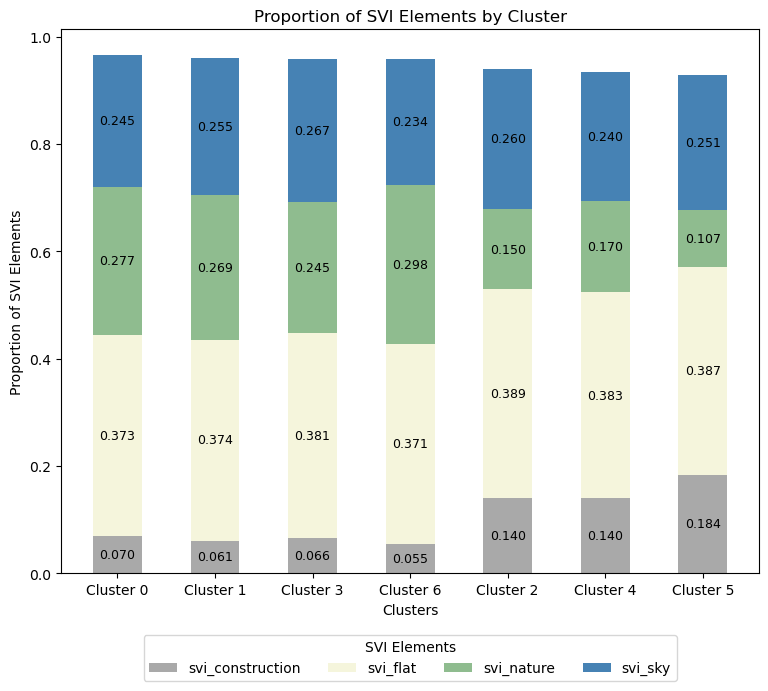

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame
df = points_with_svi_road_summary 

# Extracting relevant columns
data = df[['svi_construction', 'svi_flat', 'svi_nature', 'svi_sky']]
data['rows'] = ['Cluster ' + str(x) for x in df['cluster_id']]
data = data.set_index('rows')

# Assuming the rest of your processing is correct and just picking up from the plotting part with the new colors
proportional_data_filtered = proportional_data.drop('Cluster -1')
cluster_order_with_space = ['Cluster 0', 'Cluster 1', 'Cluster 3', 'Cluster 6', 'Cluster 2', 'Cluster 4', 'Cluster 5']
proportional_data_sorted = proportional_data_filtered.loc[cluster_order_with_space]

# Creating an artificial space in the bar plot
# index_with_space = np.array([0, 0.8, 1.6, 2.4, 3.6, 4.4, 5.2])  # Leaving a gap between index 3 and 5
index_with_space = np.array([0, 0.8, 1.6, 2.4, 3.2, 4.0, 4.8])  # Leaving a gap between index 3 and 5
bar_width = 0.4
grouped_colors = ['darkgray', 'beige', 'darkseagreen', 'steelblue']  # Updated color scheme



fig, ax = plt.subplots(figsize=(9, 8))  # Larger figure size
y_offset_with_space = np.zeros(len(index_with_space))
for col, color in zip(proportional_data_sorted.columns, grouped_colors):
    bar = ax.bar(index_with_space, proportional_data_sorted[col], bar_width, bottom=y_offset_with_space, color=color, label=col)
    y_offset_with_space = y_offset_with_space + proportional_data_sorted[col]

    # Adding proportions on the bars
    for b in bar:
        height = b.get_height()
        if height > 0:  # Only display text if there's enough space
            ax.text(b.get_x() + b.get_width() / 2, b.get_y() + height / 2, f"{height:.3f}", ha='center', va='center', fontsize=9)

ax.set_xlabel('Clusters')
ax.set_ylabel('Proportion of SVI Elements')
ax.set_xticks(index_with_space)
ax.set_xticklabels(proportional_data_sorted.index)
ax.set_title('Proportion of SVI Elements by Cluster')

# Positioning the legend horizontally below the plot
ax.legend(title='SVI Elements', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)

plt.subplots_adjust(bottom=0.2)  # Adjusting bottom to make space for the legend

plt.show()


In [25]:
road_columns = ['motorway', 'primary', 'residential', 'secondary', 'service',
       'tertiary']
road_columns = [ 'primary', 'residential', 'secondary', 
       'tertiary']

## Road Class by Cluster

C:\Users\Fan_Z\AppData\Local\Temp\ipykernel_17168\3590192488.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  road_data['rows'] = ['Cluster ' + str(x) for x in df['cluster_id']]


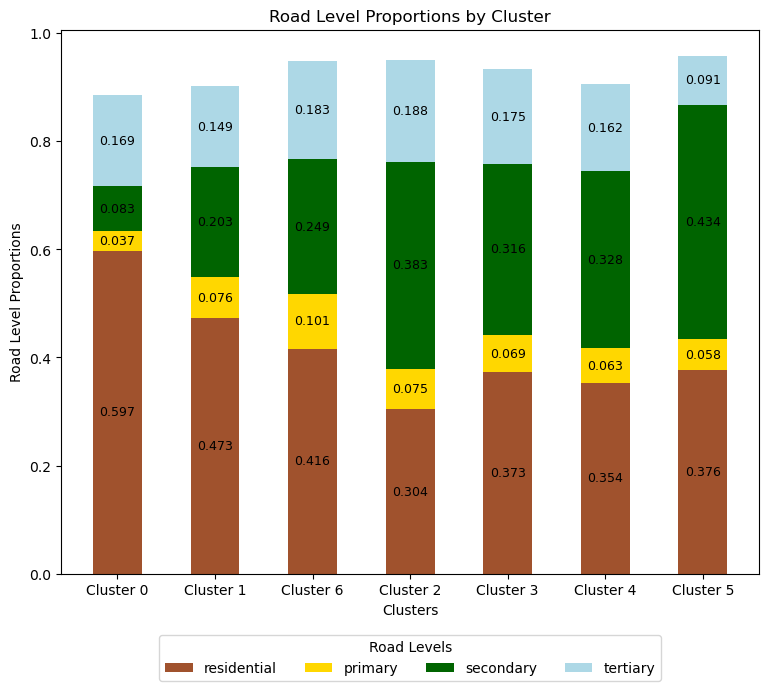

In [26]:
# Adjusting the code to group Cluster 1, 2, 6 together and Cluster 2, 3, 4, 5 together

# Extracting road level related columns
road_data = df[['residential', 'primary',  'secondary',  'tertiary' ]]
road_data['rows'] = ['Cluster ' + str(x) for x in df['cluster_id']]
road_data = road_data.set_index('rows')

# Removing 'Cluster -1' and sorting the clusters
road_data_filtered = road_data.drop('Cluster -1')
cluster_order_with_space = ['Cluster 0', 'Cluster 1', 'Cluster 6', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
road_data_sorted = road_data_filtered.loc[cluster_order_with_space]

# Creating an artificial space in the bar plot
index_with_space = np.array([0, 1, 2, 3, 5, 6, 7])  # Leaving a gap between index 3 and 5
bar_width = 0.4
road_colors = ['sienna', 'gold', 'darkgreen', 'lightblue', 'pink', 'grey', 'purple', 'orange', 'brown']

# Desired order with space: 1, 2, 6, (space), 2, 3, 4, 5
cluster_order_with_new_grouping = ['Cluster 0', 'Cluster 1', 'Cluster 6', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
road_data_new_grouped = road_data_sorted.loc[cluster_order_with_new_grouping]

# Creating a new space in the bar plot
#index_with_new_space = np.array([0, 0.8, 1.6, 2.8, 3.6, 4.4, 5.2])   # Leaving a gap after index 2
index_with_new_space = np.array([0, 0.8, 1.6, 2.4, 3.2, 4.0, 4.8])  # Leaving a gap between index 3 and 5

# Plotting with the new grouping
fig, ax = plt.subplots(figsize=(9,8))
y_offset_with_new_space = np.zeros(len(index_with_new_space))
for col, color in zip(road_data_new_grouped.columns, road_colors):
    bar = ax.bar(index_with_new_space, road_data_new_grouped[col], bar_width, bottom=y_offset_with_new_space, color=color, label=col)
    y_offset_with_new_space = y_offset_with_new_space + road_data_new_grouped[col]

    # Adding data labels
    for b in bar:
        height = b.get_height()
        if height > 0:  # Display text if there's enough space
            ax.text(b.get_x() + b.get_width() / 2, b.get_y() + height / 2, f"{height:.3f}", ha='center', va='center', fontsize=9)

# Adjusting labels, title, and legend
ax.set_xlabel('Clusters')
ax.set_ylabel('Road Level Proportions')
ax.set_xticks(index_with_new_space)
ax.set_xticklabels(road_data_new_grouped.index)
ax.set_title('Road Level Proportions by Cluster')


# Positioning the legend horizontally below the plot
ax.legend(title='Road Levels', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)

plt.subplots_adjust(bottom=0.2)  
# Display the chart
plt.show()



## Function Scenario by Cluster

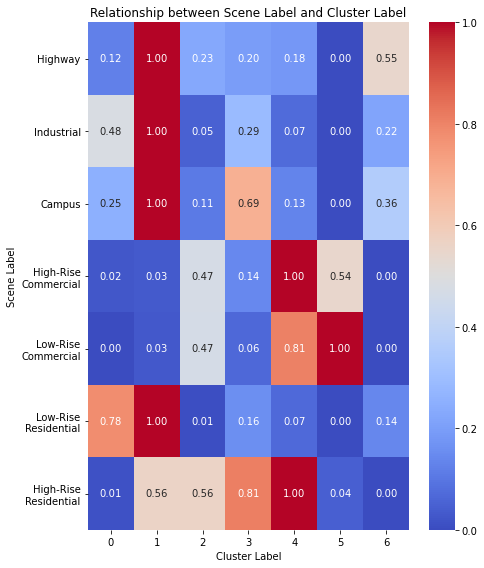

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Reading the uploaded CSV file
file_path = 'data/1216_kmeans/1216_clusters with urban scenes.csv'
df_chord = pd.read_csv(file_path) 
df_chord = df_chord[df_chord['cluster_label'] != -1]
selected_urban_scenes = ['high-rise_commercial', 'low-rise_commercial', 'colonial_residential', 'HDB_residential', 'highway', 'industrial', 'campus']
df_chord = df_chord[df_chord['scene_label'].isin(selected_urban_scenes)] 

# Crosstabulating the cluster_label and scene_label
cross_tab = pd.crosstab(df_chord['cluster_label'], df_chord['scene_label'])

# Normalizing the data
scaler = MinMaxScaler()
cross_tab_normalized = pd.DataFrame(scaler.fit_transform(cross_tab), columns=cross_tab.columns, index=cross_tab.index)

# Reordering the columns
ordered_columns = ['highway', 'industrial', 'campus', 'high-rise_commercial', 'low-rise_commercial', 'colonial_residential', 'HDB_residential']
cross_tab_normalized = cross_tab_normalized[ordered_columns]

# Creating a mapping for more formal names
scene_label_mapping = {
    'high-rise_commercial': 'High-Rise\nCommercial',
    'low-rise_commercial': 'Low-Rise\nCommercial',
    'colonial_residential': 'Low-Rise\nResidential',
    'HDB_residential': 'High-Rise\nResidential',
    'highway': 'Highway',
    'industrial': 'Industrial',
    'campus': 'Campus'
}

# Applying the mapping to the y-axis labels
cross_tab_normalized.rename(columns=scene_label_mapping, inplace=True)
cross_tab_normalized_transposed = cross_tab_normalized.T

# Plotting the heatmap
plt.figure(figsize=(7, 8))
sns.heatmap(cross_tab_normalized_transposed, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Relationship between Scene Label and Cluster Label')
plt.xlabel('Cluster Label')
plt.ylabel('Scene Label')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
